# **Importing Libraries**

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import csv
import pandas as pd
import random
import numpy as np
from keras import regularizers
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import nltk
nltk.download('wordnet')
import itertools
from string import ascii_lowercase
from functools import reduce
import seaborn as sns
from sklearn.model_selection import train_test_split
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True



## **Introduction**
Identifying harassment in social media discussions is vital, as is determining the number of unpleasant sentiments conveyed inside the comment. Organizations can save time and manual labor in regulating these platforms by automating this comment classification approach.The primary purpose is to determine the level of negativity and toxicity in internet comments. This could help to identify people who abuse individuals. As a result, it will eventually assist in the execution of policies and the penalty of individuals who do not obey, which can subsequently be used to reduce the level of toxicity in discussions. Using LSTM, CNN and FastText we aspire to build a multi-label classification model that separates comments into six groups according to their toxicity level: toxic, severe toxic, obscene, threat, insult, and identity-hate.

**We have used FastText word embedding to make the model more efficient even on the unseen data.**

## **Importing Data**
The data that we have used for the model is Kaggle’s Toxic Comment Classification Dataset on Wikipedia’s Talk page edits.

In [27]:
train_path='/content/justice.csv'
train=pd.read_csv(train_path)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
train.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",501,7,2,True,majority opinion,reversed,NaN
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment


,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",501,7,2,True,majority opinion,reversed,NaN
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment


In [30]:
train.isnull().sum()

Unnamed: 0              0
ID                      0
name                    0
href                    0
docket                  0
term                    0
first_party             1
second_party            1
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64

Unnamed: 0              0
ID                      0
name                    0
href                    0
docket                  0
term                    0
first_party             1
second_party            1
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64

In [31]:
train.dropna(inplace=True)

In [32]:
train['first_party_winner'].value_counts()

True     2067
False    1031
Name: first_party_winner, dtype: int64

True     2067
False    1031
Name: first_party_winner, dtype: int64

In [33]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train['first_party_winner']= label_encoder.fit_transform(train['first_party_winner'])

In [34]:
train['first_party_winner'].value_counts()

1    2067
0    1031
Name: first_party_winner, dtype: int64

1    2067
0    1031
Name: first_party_winner, dtype: int64

In [35]:
labels = ['first_party_winner']
y = train[labels].values  
print(y[:5])

[[1]
 [1]
 [1]
 [1]
 [1]]
[[1]
 [1]
 [1]
 [1]
 [1]]


In [36]:
train=train[['facts', 'first_party_winner']]

In [37]:
train.head()

,facts,first_party_winner
1,<p>Joan Stanley had three children with Peter ...,1
2,<p>John Giglio was convicted of passing forged...,1
3,"<p>The Idaho Probate Code specified that ""male...",1
4,"<p>Miller, after conducting a mass mailing cam...",1
5,<p>Ernest E. Mandel was a Belgian professional...,1


,facts,first_party_winner
1,<p>Joan Stanley had three children with Peter ...,1
2,<p>John Giglio was convicted of passing forged...,1
3,"<p>The Idaho Probate Code specified that ""male...",1
4,"<p>Miller, after conducting a mass mailing cam...",1
5,<p>Ernest E. Mandel was a Belgian professional...,1


# **Data Visualization**

In [38]:
lens=train['facts'].str.len()

Text(0, 0.5, 'Number of Comments')

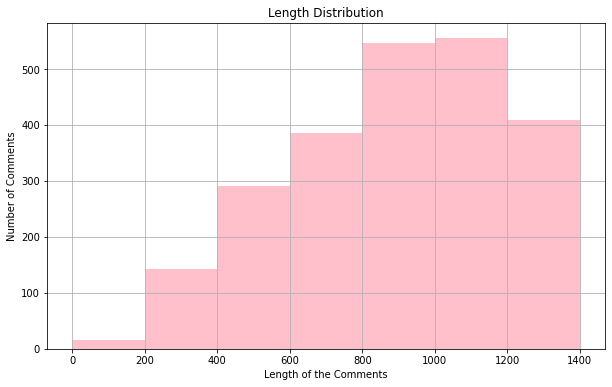

Text(0, 0.5, 'Number of Comments')

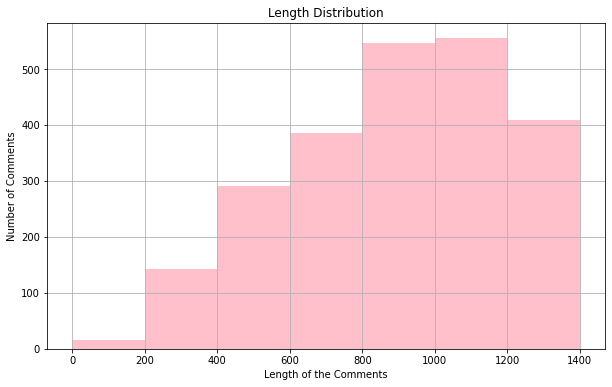

In [39]:
resize = np.arange(0, 1500,200)
lens.hist(color='pink', figsize=(10, 6), bins=resize,width=200 )
plt.title('Length Distribution')
plt.xlabel('Length of the Comments')
plt.ylabel('Number of Comments')

Maximum comment length are ranging from 0 to 200

Number of toxic comments in the dataset are significantly higher. Identity Hate comments, on the other hand, are the lowest.

# **Data Pre-Processing**



In [40]:
train.shape

(3098, 2)

(3098, 2)

In [41]:
##Text Normalization

def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 

In [42]:
train_texts = [] 
for line in tqdm_notebook(train['facts'], total=3098): 
    train_texts.append(clean_text(line))

<ipython-input-18-1087b50cb154>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(train['facts'], total=3098):


  0%|          | 0/3098 [00:00<?, ?it/s]

<ipython-input-42-1087b50cb154>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(train['facts'], total=3098):


  0%|          | 0/3098 [00:00<?, ?it/s]

In [43]:
##Lemmatization

lemmatizer= WordNetLemmatizer()
def lemma(text, lemmatization=True):
  output=''
  if lemmatization:
    text=text.split(' ')
    for word in text:
      word1 = lemmatizer.lemmatize(word, pos = "n") #noun 
      word2 = lemmatizer.lemmatize(word1, pos = "v") #verb
      word3 = lemmatizer.lemmatize(word2, pos = "a") #adjective
      word4 = lemmatizer.lemmatize(word3, pos = "r") #adverb
      output=output + " " + word4
  else:
    output=text
  
  return str(output.strip())

In [44]:
lema_train_text=[]
for line in train_texts:
    lema_train_text.append(lemma(line))

In [45]:
##Stopwords Removal

stopword_list=[]
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')


for letter in dual_alpha_list:
    stopword_list.append(letter)

In [46]:
print(stopword_list)
print(len(stopword_list))
print(len(lema_train_text))

['b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak', 'al', 'ao', 'ap', 'aq', 'ar', 'au', 'av', 'aw', 'ax', 'ay', 'az', 'ba', 'bb', 'bc', 'bd', 'bf', 'bg', 'bh', 'bi', 'bj', 'bk', 'bl', 'bm', 'bn', 'bo', 'bp', 'bq', 'br', 'bs', 'bt', 'bu', 'bv', 'bw', 'bx', 'bz', 'ca', 'cb', 'cc', 'cd', 'ce', 'cf', 'cg', 'ch', 'ci', 'cj', 'ck', 'cl', 'cm', 'cn', 'co', 'cp', 'cq', 'cr', 'cs', 'ct', 'cu', 'cv', 'cw', 'cx', 'cy', 'cz', 'da', 'db', 'dc', 'dd', 'de', 'df', 'dg', 'dh', 'di', 'dj', 'dk', 'dl', 'dm', 'dn', 'dp', 'dq', 'dr', 'ds', 'dt', 'du', 'dv', 'dw', 'dx', 'dy', 'dz', 'ea', 'eb', 'ec', 'ed', 'ee', 'ef', 'eg', 'eh', 'ei', 'ej', 'ek', 'el', 'em', 'en', 'eo', 'ep', 'eq', 'er', 'es', 'et', 'eu', 'ev', 'ew', 'ex', 'ey', 'ez', 'fa', 'fb', 'fc', 'fd', 'fe', 'ff', 'fg', 'fh', 'fi', 'fj', 'fk', 'fl', 'fm', 'fn', 'fo', 'fp', 'fq', 'fr', 'fs', 'ft', 'fu', 'fv', 'fw', 'fx

In [47]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())

#Removing Stopwords from Train Data
processed_train_data = [] 
for line in tqdm_notebook(lema_train_text, total=3098): 
    processed_train_data.append(remove_stopwords(line))

<ipython-input-23-2cd021c24829>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(lema_train_text, total=3098):


  0%|          | 0/3098 [00:00<?, ?it/s]

<ipython-input-47-2cd021c24829>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(lema_train_text, total=3098):


  0%|          | 0/3098 [00:00<?, ?it/s]

In [48]:
max_features=14004
maxpadlen = 400          
val_split = 0.2      
embedding_dim_fasttext = 300

In [49]:
#Tokenization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)

In [50]:
import pickle
with open("tokenizer", 'wb') as f:
  pickle.dump(tokenizer, f)

In [106]:
#Indexing
word_index=tokenizer.word_index
print(len(word_index))

14004


In [107]:
#padding
training_padded=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')

In [108]:
print('Tokenized sentences: \n', training_padded[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  43 1186    5 1187    3  407    2  746 9941    5   61  151    8    3
   74  147  549    8  824 6784    3 2683  538    3 2027   29  844    8
    3 4587 1718   11   74 1790   22  349    4  402  114   14  641   56
   29   10 1040  151  237 6784  195    4  402    5 2028 1038    1 2410
    2   16 2583 1188 1791    8    1 3576   34    2    8 8058    5   58
   14 3577   74  634 2683  242  463  356  219    1  503 9942  329   10
  349    4  402  114  641   56    5 1650  579  291 1022 6784  123 8058
    5 3577  195    4  844  114   47 3578  641   56    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

In [109]:
train.drop(columns=['first_party_winner'], inplace=True)

In [110]:
#Splitting data into Training and Validation Set

x_train, x_val, y_train, y_val = train_test_split(training_padded, y, test_size=0.2, random_state=2)

In [111]:
print('Number of entries in each category: ')
print('Training: ', y_train.sum(axis=0))
print('Validation: ', y_val.sum(axis=0))

Number of entries in each category: 
Training:  [1650]
Validation:  [417]


In [ ]:
embeddings_index_fasttext = {}
f = open('/content/drive/MyDrive/projects/Kaggle competition - jigsaw/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    line.encode('utf-8').strip()
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector

# **LSTM**

In [ ]:
model_1 = tf.keras.Sequential([
	tf.keras.layers.Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings'),
  tf.keras.layers.Input(shape=(maxpadlen, ),dtype='int32'),
  tf.keras.layers.LSTM(40,return_sequences=True, name='lstm_layer'),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dropout(.1),
  tf.keras.layers.Dense(30, activation='relu', kernel_initializer='he_uniform'),
	tf.keras.layers.Dropout(.1),
	tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 400, 300)          4201500   
                                                                 
 input_9 (InputLayer)        multiple                  0         
                                                                 
 lstm_layer (LSTM)           (None, 400, 40)           54560     
                                                                 
 global_max_pooling1d_8 (Glo  (None, 40)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_16 (Dropout)        (None, 40)                0         
                                                                 
 dense_18 (Dense)            (None, 30)                1230      
                                                      

In [ ]:
history_1 = model_1.fit(x_train,y_train, epochs=20, batch_size=8,  validation_data=(x_val, y_val))

Epoch 1/20
310/310 [==============================] - 8s 24ms/step - loss: 0.6329 - accuracy: 0.6663 - val_loss: 0.6308 - val_accuracy: 0.6726
Epoch 2/20
310/310 [==============================] - 6s 20ms/step - loss: 0.6253 - accuracy: 0.6659 - val_loss: 0.6426 - val_accuracy: 0.6613
Epoch 3/20
310/310 [==============================] - 7s 24ms/step - loss: 0.6068 - accuracy: 0.6739 - val_loss: 0.6460 - val_accuracy: 0.6355
Epoch 4/20
310/310 [==============================] - 6s 20ms/step - loss: 0.5839 - accuracy: 0.6941 - val_loss: 0.6402 - val_accuracy: 0.6468
Epoch 5/20
310/310 [==============================] - 7s 23ms/step - loss: 0.5527 - accuracy: 0.7215 - val_loss: 0.6544 - val_accuracy: 0.6532
Epoch 6/20
310/310 [==============================] - 6s 21ms/step - loss: 0.5098 - accuracy: 0.7518 - val_loss: 0.6688 - val_accuracy: 0.6355
Epoch 7/20
310/310 [==============================] - 7s 22ms/step - loss: 0.4348 - accuracy: 0.7982 - val_loss: 0.7502 - val_accuracy: 0.6516

In [ ]:
model_1.save('judgement')

In [ ]:
!zip -r /content/file.zip /content/judgement

  adding: content/judgement/ (stored 0%)
  adding: content/judgement/variables/ (stored 0%)
  adding: content/judgement/variables/variables.data-00000-of-00001 (deflated 30%)
  adding: content/judgement/variables/variables.index (deflated 62%)
  adding: content/judgement/keras_metadata.pb (deflated 89%)
  adding: content/judgement/assets/ (stored 0%)
  adding: content/judgement/saved_model.pb (deflated 89%)


# **Plotting Graph for LSTM**

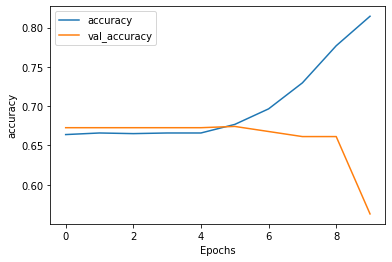

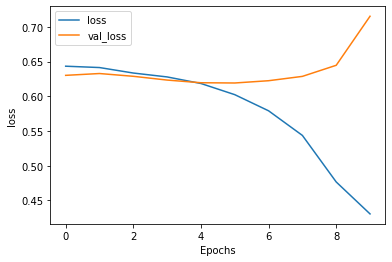

In [ ]:
def plot_graphs(history_1, string):
  plt.plot(history_1.history[string])
  plt.plot(history_1.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_1, 'accuracy')
plot_graphs(history_1, 'loss')